# Ajustes de Espectros XPS

Este notebook tiene como objetivo leer archivos con datos de XPS guardados en distintas carpetas. Un carpeta por cada región del espectro de Energía. Luego se grafican todos los espectros crudos para tener una idea global de como se ven. La carga de espectros y los graficos generales, se intentan que se carguen usando el mismo codigo reutilizable. A futuro, quizas sería mejor crear alguna función que haga ese trabajo.

Por otro lado, se pretende realizar ajustes de estos espectros, considerando un modelo compuesto por una linea de base y varias componentes más. Finalmente, se busca realizar un ajuste "automático" de todo el set de espèctros de una región. Dado que se estudia daño por irradiación, cada región va cambiando gradualmente a lo largo del tiempo (número o nombre de espectros).

Para el ajuste, se prtende usar el paquete `lmfit` (https://lmfit.github.io/lmfit-py/)

# Se importan los paquetes necesarios

In [1]:
# --- glob permite buscar archivos en carpetas --------------------------------
import glob

# --- matplotlib --------------------------------------------------------------
import matplotlib.pyplot as plt

# --- Numpy -------------------------------------------------------------------
import numpy as np

# --- Pandas ------------------------------------------------------------------
import pandas as pd

# --- LMFIT -------------------------------------------------------------------
from lmfit import Parameters, minimize, report_fit
from lmfit.models import ConstantModel, GaussianModel, LinearModel, VoigtModel

# --- scipy -------------------------------------------------------------------
from scipy.special import wofz

In [2]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)

In [4]:
# Definimos el formato de los gráficos

import seaborn as sns  # library for visualization

# sns.set_style("ticks")
# sns.set_context("paper")
sns.set_context("notebook")
# sns.set_context("talk")
# sns.set_context("poster")


import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MultipleLocator

# plt.style.use("classic")
# plt.style.use(['seaborn-ticks','seaborn-paper'])

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['CMU Sans Serif']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

# plt.rc('font', family='sans-serif', size=8)
# plt.rc('text', usetex=True)
# plt.rc('xtick', labelsize=8)
# plt.rc('ytick', labelsize=8)
# plt.rc('axes', labelsize=8)
# plt.rc('legend', fontsize=8)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'cm'
# plt.rcParams['text.latex.preamble'] = [
#        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#        r'\usepackage{helvet}',    # set the normal font here
#        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
#        r'\sansmath',               # <- tricky! -- gotta actually tell tex to use!
#        r'\usepackage[version=4]{mhchem}'
#        ]


# --- Tamaño de los gráficos --------------------------------------------------
# width as measured in inkscape
# single_column = 3.3
# double_column = 7
single_column = 3.3  # ...ACS
double_column = 7  # ... ACS
# height = width / 1.618

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['savefig.dpi'] = 600

### Enrgía de cada fuente de RX

In [5]:
AlKa = 1486.7
MgKa = 1253.6


def KE(x):
    return x


def BE(x):
    return x - AlKa

# Estructura de Datos y Carga Archivos

Para poder cargar los archivos correctmente, se recomienda ordenar los archivos de DATA (.txt) en subcarpetas con nombre de la región del espectro correspondiente. Por ej. si fueran nanopartículasd de Ag protegidas con DDT:

    AgNPDDT
    |
    +-- VB
    |   |  
    |   +-- VB_1.txt
    |   +-- VB_2.txt
    |   +...........
    |
    +-- S2p_10
    |   |  
    |   +-- S2p_10_1.txt
    |   +-- S2p_10_2.txt
    |   +...........
    |
    +-- Ag3d_10
    |   |  
    |   +-- Ag3d_10_1.txt
    |   +-- Ag3d_10_2.txt
    |   +...........
    |    
    +-- ...........
     

Para cargar los datos, usamos la función ``load_files("nombre_de_la_carpeta")``, la cual crea un `array` del mismo nombre de la carpta con los datos. 
Para graficas todos los datos para tener una visión global del comportamiento, creamos la función `plot_all("lista de regiones")`. 
Se definen a continuación:

In [6]:
#############################################################################
#                                                                           #
#                            Functions                                      #
#                                                                           #
#############################################################################

# ---------------------------------------------------------------------------
#                     Load data
# ---------------------------------------------------------------------------
def load_files_txt(path="samefolder"):
    """Función para cargar archivos dentro de una carpeta."""
    if path == "samefolder":
        list_XPS_files = glob.glob("*.txt")
    else:
        list_XPS_files = glob.glob(path + "/*.txt")
        print(path)
    # creo lista con los nombres de los archivos ordenados alfabéticamente
    list_XPS_files.sort()

    data = [
        np.genfromtxt(
            list_XPS_files[0],
            delimiter="\t",
            skip_header=4,
            usecols=[1],
            autostrip=True,
        )
        * (-1)  # <-- para poner la BE negativa
    ]
    # Agregamos a la listo los elementos de CPS para [1:]
    for i, f_name in enumerate(list_XPS_files):
        f_name = np.genfromtxt(
            list_XPS_files[i],
            delimiter="\t",
            skip_header=4,
            usecols=[2],
            autostrip=True,
        )
        data.append(f_name)  # Salida es una lista
    # Convertimos la lista "data" en un array con el nombre de la región
    data_array = np.array(data)

    return data_array


# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
#                Plot all data
# ---------------------------------------------------------------------------
def plot_all(list_regions):
    """Grafica todos los espectros cargados"""

    col = 2

    if len(list_regions) % 2 == 0:
        row = len(list_regions) / 2
    else:
        row = len(list_regions) / 2 + 0.5

    row = int(row)

    fig, axs = plt.subplots(row, col, figsize=(12, 5 * row), constrained_layout=True)

    axs = axs.flatten()
        
    for i, reg in enumerate(list_regions):
        for p in range(1,len(reg)):
            axs[i].plot(reg[0], reg[p])
            axs[i].set_xlabel("BE [eV]")

    return plt.show()
# ---------------------------------------------------------------------------


# Cargamos los espectros
Para cargar la funciones operamos de la siguiente manera: `name_data_array = load_files_txt("nombre_carpeta")`, donde `name_data_array` será el nombre de la variable `numpy.array` que contenga los espectros contenidos en la carpeta `nombre_carpeta`.

In [9]:
path = "/home/julio/Trabajo/LINEAS_INVESTIGACION/Radiacion/AgNPs-SC12_Temperatura_German/25C/"

VB = load_files_txt(path + "VB")
S2p_10 = load_files_txt(path + "S2p_10")
Ag3d_10 = load_files_txt(path + "Ag3d_10")
AgMNN_10 = load_files_txt(path + "AgMNN_10")

/home/julio/Trabajo/LINEAS_INVESTIGACION/Radiacion/AgNPs-SC12_Temperatura_German/25C/VB
/home/julio/Trabajo/LINEAS_INVESTIGACION/Radiacion/AgNPs-SC12_Temperatura_German/25C/S2p_10
/home/julio/Trabajo/LINEAS_INVESTIGACION/Radiacion/AgNPs-SC12_Temperatura_German/25C/Ag3d_10
/home/julio/Trabajo/LINEAS_INVESTIGACION/Radiacion/AgNPs-SC12_Temperatura_German/25C/AgMNN_10


## Graficamos todos los espectros para una observación general
Para graficar, creamos una lista con los nombres de los array de datos cargados anteriormente.

In [10]:
regiones = [
    VB,
    S2p_10,
    Ag3d_10,
    AgMNN_10,
]

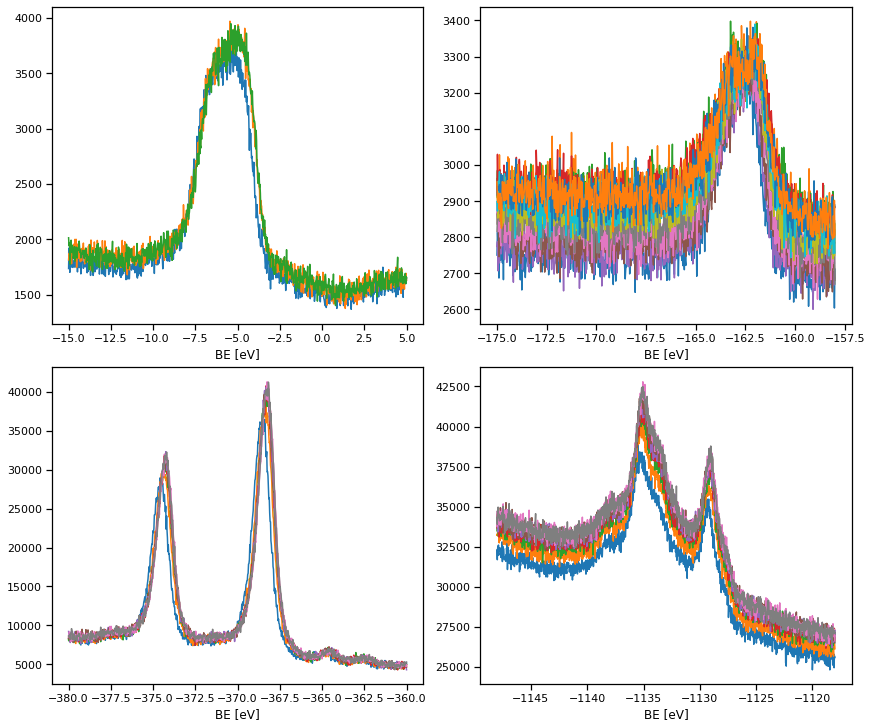

In [11]:
plot_all(regiones)

# Ag3d

## Ajuste de Ag3d

In [12]:
# Definimos la separación de los picos, SOS : Spin-Orbit Splitting

# Ag3d ---> SOS = 6 eV

SOS = 6.0

### Ajustamos un solo espectro

In [13]:
# A modo de buscar valores iniciales mas cercanos a los reales para los futuros
# ajustes, creamos un array con los datos de los extremos del espectro para estimar
# los valores de la linea de base lineal

XPS_data = Ag3d_10

x_izq = XPS_data[0][:40]
x_der = XPS_data[0][-40:]
x_extremos = np.concatenate((x_izq, x_der))

y_izq = XPS_data[1][:40]
y_der = XPS_data[1][-40:]
y_extremos = np.concatenate((y_izq, y_der))

# ajustamos
bkg = LinearModel(prefix="bkg_")
pars = bkg.guess(y_extremos, x=x_extremos,)
# con la línea anterior, estimamos mejor los valores de inicio para la linea de base

# El modelo para "ajustar" solo contiene la linea de base
mod = bkg

init = mod.eval(pars, x=x_extremos)

print(pars)

Parameters([('bkg_slope', <Parameter 'bkg_slope', value=-175.53495706059147, bounds=[-inf:inf]>), ('bkg_intercept', <Parameter 'bkg_intercept', value=-58484.309112418836, bounds=[-inf:inf]>)])


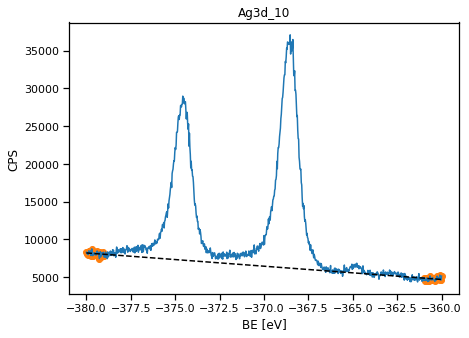

In [14]:
XPS_data = Ag3d_10  # <---- Nombre de la región

################################################################################
# --- Graficamos de forma genérica ---------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 5),)

ax1.plot(XPS_data[0], XPS_data[1])
ax1.scatter(x_extremos, y_extremos, c="C1")
ax1.plot(x_extremos, init, "k--", label="initial fit")

plt.xlabel("BE [eV]")
plt.ylabel("CPS")

plt.title("Ag3d_10")
plt.show()

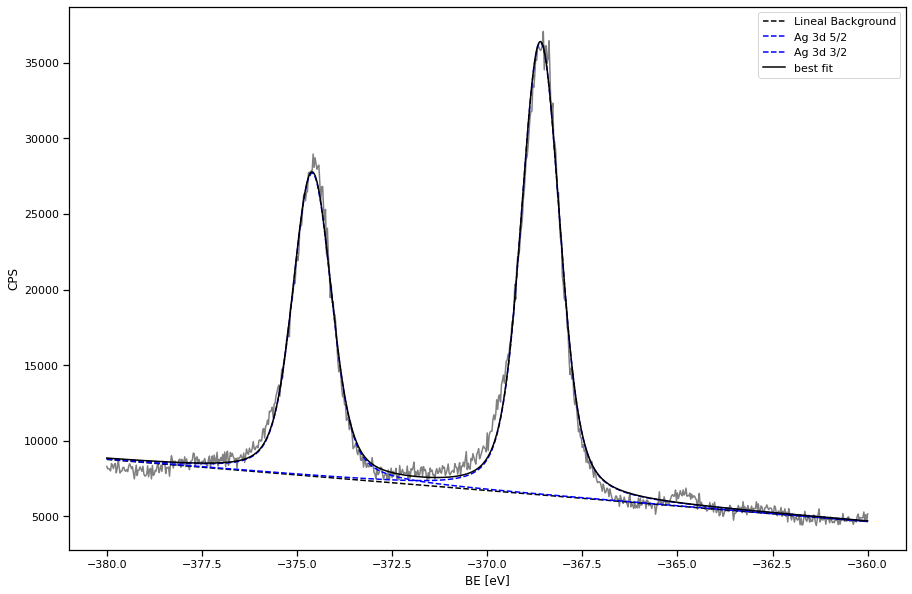

In [15]:
x = XPS_data[0]
y = XPS_data[1]

# --- Funciones de ajuste ---
bkg = LinearModel(prefix="bkg_")
pars = bkg.guess(  # <--- con esto, estimamos mejor los valores de inicio para la linea de base
    y_extremos, x=x_extremos,
)

# Aquí definimos los picos

V1 = VoigtModel(x=x, prefix="V1_")
pars.update(V1.make_params())
pars["V1_amplitude"].set(value=10000, min=10)
pars["V1_center"].set(value=-368)
pars["V1_sigma"].set(value=0.3, min=0.2, max=1)
pars["V1_gamma"].set(value=0.2, vary=False)

V2 = VoigtModel(x=x, prefix="V2_")
pars.update(V2.make_params())
pars["V2_amplitude"].set(expr="V1_amplitude*0.67")
pars["V2_center"].set(expr="V1_center - %s" % SOS)
pars["V2_sigma"].set(expr="V1_sigma")
pars["V2_gamma"].set(expr="V1_gamma")

# --- modelo de ajuste ---------------------------------------------
mod = bkg + V1 + V2  # + gauss1 + gauss2
# ---  Ajuste ------------------------------------------------------
init = mod.eval(pars, x=x)  # <--- se cargan los parámetros iniciales del ajuste
out = mod.fit(y, pars, x=x)  # <--- Se hace el ajuste
comps = out.eval_components(
    x=x
)  # <--- se evalua cada componente de ajuste (por cada función del modelo)
# print(out.fit_report())
# report_fit(out.params)

# --- Creamos las curvas de cada componente + linea de base
C1plt = comps["bkg_"] + comps["V1_"]
C2plt = comps["bkg_"] + comps["V2_"]
# C3plt = comps["bkg_"] + comps["V3_"]
# C4plt = comps["bkg_"] + comps["V4_"]
# C5plt = comps["bkg_"] + comps["V5_"]
# C6plt = comps["bkg_"] + comps["V6_"]

# --- Graficamos -----------------------------------------------------

plt.figure(figsize=(15, 10))

plt.plot(x, y, "grey")
plt.plot(x, comps["bkg_"], "k--", label="Lineal Background")
plt.plot(x, C1plt, "--", color="b", label="Ag 3d 5/2")
plt.plot(x, C2plt, "--", color="b", label="Ag 3d 3/2")
# plt.plot(axBE_p, C3plt, "--", color="orange", label="Voigt peak 1")
# plt.plot(axBE_p, C4plt, "--", color="orange", label="Voigt peak 1")
# plt.plot(axBE_p, C5plt, "--", color="green", label="Voigt peak 1")
# plt.plot(axBE_p, C6plt, "--", color="green", label="Voigt peak 1")
plt.plot(x, out.best_fit, "k-", label="best fit")
plt.xlabel("BE [eV]")
plt.ylabel("CPS")
plt.legend(loc="best")

plt.show()

In [16]:
pars.pretty_print()

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
V1_amplitude      1e+04       10      inf     None     True     None     None
V1_center          -368     -inf      inf     None     True     None     None
V1_fwhm          0.9444     -inf      inf     None    False 1.0692*V1_gamma+sqrt(0.8664*V1_gamma**2+5.545083*V1_sigma**2)     None
V1_gamma            0.2     -inf      inf     None    False     None     None
V1_height          8386     -inf      inf     None    False (V1_amplitude/(max(1e-15, V1_sigma*sqrt(2*pi))))*wofz((1j*V1_gamma)/(max(1e-15, V1_sigma*sqrt(2)))).real     None
V1_sigma            0.3      0.2        1     None     True     None     None
V2_amplitude       6700     -inf      inf     None    False V1_amplitude*0.67     None
V2_center          -374     -inf      inf     None    False V1_center - 6.0     None
V2_fwhm          0.9444     -inf      inf     None    False 1.0692*V2_gamma+sqrt(0.8664*V2_gamma**2+5.545083*V2_sigma**2)     None


### Definimos el rango de datos sobr los cuales se hace el ajuste

In [17]:
# ---- Rango de ajuste -----
izq = -378
der = -363

###############################################################################
###############################################################################
###############################################################################
# --- renombramos los array con todos los datos completos ---------------------
x_full = XPS_data[0]
y_full_data = XPS_data[1:]

print("Esta región tiene:", x_full.shape, y_full_data.shape, "datos")

# --- obtenemos los valores de cada "index" del array correspondiente a los límites
lim_izq = np.min(np.where(x_full > izq))
lim_der = np.max(np.where(x_full < der))

print("Al poner limites, tomamos los datos entre los índices:", lim_izq, lim_der)

# --- Definimos los array sobre los que se hacen los ajustes
x = x_full[lim_izq:lim_der]
y_data = y_full_data[:, lim_izq:lim_der]

print("La sección del espectro ahora tiene:", x.shape, y_data.shape, "datos")

# --- Buscamos los valores de los extremos del espectro para los parámetros de la línea de base
x_izq = x[:40]
x_der = x[-40:]
x_extremos = np.concatenate((x_izq, x_der))

y_izq = y_data[1][:40]
y_der = y_data[1][-40:]
y_extremos = np.concatenate((y_izq, y_der))

Esta región tiene: (801,) (8, 801) datos
Al poner limites, tomamos los datos entre los índices: 81 679
La sección del espectro ahora tiene: (598,) (8, 598) datos


### Funciones de ajuste

In [18]:
# Definimos las funciones para ajustar todo el set de datos


def doublet_nd_V(x, amp, center, sigma, gamma):
    """Definimos una función formada por dos picos Voigt"""
    return amp * np.real(
        wofz((x - center + 1j * gamma) / sigma / np.sqrt(2))
    ) / sigma / np.sqrt(2 * np.pi) + amp * 0.67 * np.real(
        wofz((x - center + SOS + 1j * gamma) / sigma / np.sqrt(2))
    ) / sigma / np.sqrt(
        2 * np.pi
    )


def gauss(x, amp_g, cen_g, sig_g):
    """Gaussian lineshape."""
    return amp_g * np.exp(-((x - cen_g) ** 2) / (2.0 * sig_g ** 2))


def bkg_lin(x, slope, intercept):
    """Bakground lineal"""
    return x * slope + intercept

In [19]:
# --- Otra forma de definir las funciones ---


def doblete_voigt(x, amp, center, sigma, gamma):
    """Definimos una función formada por dos picos Voigt"""
    return amp * np.real(
        wofz((x - center + 1j * gamma) / sigma / np.sqrt(2))
    ) / sigma / np.sqrt(2 * np.pi) + amp * 0.67 * np.real(
        wofz((x - center + SOS + 1j * gamma) / sigma / np.sqrt(2))
    ) / sigma / np.sqrt(
        2 * np.pi
    )

### Modelo de ajuste

In [20]:
# --- Modelo de ajuste con varias funciones


def model_dataset(params, i, x):
    """Calculamos los parameros para todos los espectros"""
    amp = params["amp_%i" % (i + 1)]
    center = params["center_%i" % (i + 1)]
    sigma = params["sigma_%i" % (i + 1)]
    gamma = params["gamma_%i" % (i + 1)]

    amp_g = params["amp_g_%i" % (i + 1)]
    cen_g = params["cen_g_%i" % (i + 1)]
    sig_g = params["sig_g_%i" % (i + 1)]

    slope = params["slope_%i" % (i + 1)]
    intercept = params["intercept_%i" % (i + 1)]
    return (
        bkg_lin(x, slope, intercept)
        + doublet_nd_V(x, amp, center, sigma, gamma)
        + gauss(x, amp_g, cen_g, sig_g)
    )


# --- ajuste global de los datos ----------------------------------------------


def objective(params, x, y_data):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata, _ = y_data.shape
    resid = 0.0 * y_data[:]

    # make residual per data set
    for i in range(ndata):
        resid[i, :] = y_data[i, :] - model_dataset(params, i, x)

    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

### Definimos los parámetros iniciales del ajuste

In [21]:
## Damos valores de inicio, y restricciones de ajuste de los parámetros

fit_params = Parameters()
for iy, y in enumerate(y_data):
    fit_params.add("amp_%i" % (iy + 1), value=10000, min=0.0)
    fit_params.add("center_%i" % (iy + 1), value=-368, min=-369, max=-367)
    fit_params.add("sigma_%i" % (iy + 1), value=0.3, min=0.01, max=1.0)
    fit_params.add("gamma_%i" % (iy + 1), value=0.2, vary=False)

    fit_params.add("amp_g_%i" % (iy + 1), value=1000, min=0.0)
    fit_params.add("cen_g_%i" % (iy + 1), value=-365, min=-366, max=-364)
    fit_params.add("sig_g_%i" % (iy + 1), value=0.3, min=0.01, max=1.0)

    fit_params.add("slope_%i" % (iy + 1), value=-200)
    fit_params.add("intercept_%i" % (iy + 1), value=-69000)

### Ejecutamos el ajuste de todo el set de datos

In [22]:
# --- se hace el ajuste
out = minimize(objective, fit_params, args=(x, y_data))

# --- Imprimimos el reporte de los parámetros resultantes del ajuste
# report_fit(out.params)

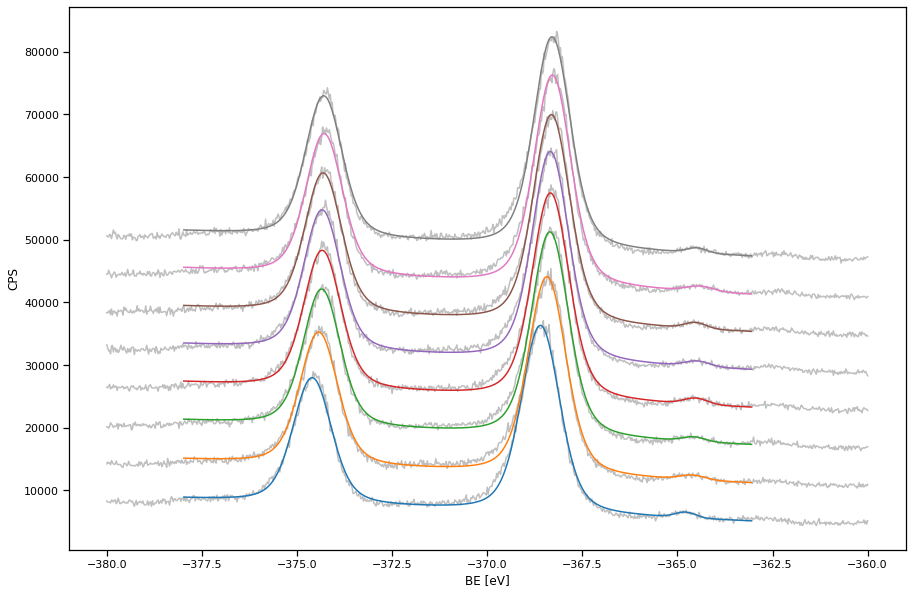

In [23]:
plt.figure(figsize=(15, 10))

offset = 6000

for i in range(len(y_data)):
    y_fit = model_dataset(out.params, i, x)
    plt.plot(x_full, y_full_data[i, :] + i * offset, "-", color="grey", alpha=0.5)
    plt.plot(x, y_fit + i * offset, "-")

plt.xlabel("BE [eV]")
plt.ylabel("CPS")
plt.show()

In [28]:
print(out.params.keys())

dict_keys(['amp_1', 'center_1', 'sigma_1', 'gamma_1', 'amp_g_1', 'cen_g_1', 'sig_g_1', 'slope_1', 'intercept_1', 'amp_2', 'center_2', 'sigma_2', 'gamma_2', 'amp_g_2', 'cen_g_2', 'sig_g_2', 'slope_2', 'intercept_2', 'amp_3', 'center_3', 'sigma_3', 'gamma_3', 'amp_g_3', 'cen_g_3', 'sig_g_3', 'slope_3', 'intercept_3', 'amp_4', 'center_4', 'sigma_4', 'gamma_4', 'amp_g_4', 'cen_g_4', 'sig_g_4', 'slope_4', 'intercept_4', 'amp_5', 'center_5', 'sigma_5', 'gamma_5', 'amp_g_5', 'cen_g_5', 'sig_g_5', 'slope_5', 'intercept_5', 'amp_6', 'center_6', 'sigma_6', 'gamma_6', 'amp_g_6', 'cen_g_6', 'sig_g_6', 'slope_6', 'intercept_6', 'amp_7', 'center_7', 'sigma_7', 'gamma_7', 'amp_g_7', 'cen_g_7', 'sig_g_7', 'slope_7', 'intercept_7', 'amp_8', 'center_8', 'sigma_8', 'gamma_8', 'amp_g_8', 'cen_g_8', 'sig_g_8', 'slope_8', 'intercept_8'])
